In [1]:
%matplotlib inline
import sys
sys.path.append("..")

# DeepTrack 2.0 - Tracking a point particle with a CNN

This tutorial demonstrates how to track a point particle with a convolutional neural network (CNN) using DeepTrack 2.0.

Specifically, this tutotial explains how to: 
* Define the procedure to generate training images
* Extract information from these images to use as labels for the training
* Define and train a neural network model
* Visually evaluate the quality of the neural network output

It is recommended to peruse this tutotial after the [deeptrack_introduction_tutorial](deeptrack_introduction_tutorial.ipynb).

## 1. Setup

Imports needed for this tutorial.

In [2]:
import deeptrack as dt

import numpy as np
import matplotlib.pyplot as plt

## 2. Define the particle

For this example, we consider a spherical particle. Specifically, scattering of a spherical particle as determined by mie thery. For this, we use `MieSphere` (see also [scatterers_example](../examples/scatterers_example.ipynb)), whose properties are controlled by the following parameters:

* `refractive_index`: The refractive index of the particle

* `radius`: The radius of the marticle

* `position`: The position of the point particle

* `position_unit`: "pixel" or "meter"

In [3]:
mie_particle = dt.MieSphere(                                         
    refractive_index=1.58,
    radius=0.5e-6,
    position=(32, 32),
    position_unit="pixel",
)

## 3. Define the optical system 

Next, we need to define the properties of the optical system. This is done using an instance of the class `Optics` (see also [optics_example](../examples/optics_example.ipynb)), which takes a set of particles (light scatterers) and convolves them with the pupil function (point spread function) of the optical system. In this tutorial, there is only one light scatterer (here, `mie_particle`).

The optics is controlled by the following parameters:

* `NA`: The numerical aperature

* `resolution`: The effective camera pixel size (m)

* `magnification`: The magnification of the optical device

* `wavelength`: The wavelength of the lightsource (m)

* `output_region`: The position of the camera and the number of pixels (x, y, width_x, width_y)

* `upscale`: upscales all calculations. Increases accuracy at the cost of speed.

In [4]:
IMAGE_SIZE = 64

brightfield_microscope = dt.Brightfield(
    NA=1.3,                
    resolution=1e-6,     
    magnification=5,
    wavelength=680e-9,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
    upscale=2
)

## 4. Create and plot the image

To view some object through an optical device, we call the optical device (here, `brightfield_microscope`) with the object we want to image (here, `point_particle`). This creates a new object (here, `imaged_particle`) that can be used to generate the desired image.

The image is finally generated by calling `imaged_particle.resolve()`.

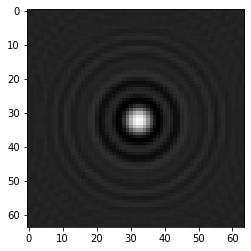

In [5]:
imaged_particle = brightfield_microscope(mie_particle)

output_image = imaged_particle.resolve()

plt.imshow(np.squeeze(output_image), cmap='gray')
plt.show()

## 5. Randomize the particle position

We can generate particles with random positions by passing to the keyword argument `position` a lambda function that returns a pair of random numbers representing the particle position. We limit the scope, by asserting that the particle is at least 10 pixels from the edge of the image.

We additionally normalize the image to be between 0 and 1. It is very common that normalizing the neural network input improves the results substantially.

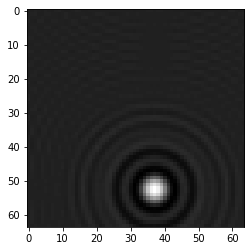

In [6]:
# Generate particle with random position

particle_with_random_position = dt.MieSphere(                                         
    refractive_index=1.58,
    radius=0.5e-6,
    position=lambda: 10 + np.random.rand(2) * (IMAGE_SIZE - 20),
    position_unit="pixel"
)

imaged_particle_with_random_position = brightfield_microscope(particle_with_random_position)

# Normalize each image between 0 and 1.
normalized_image_of_particle = imaged_particle_with_random_position + dt.NormalizeMinMax(0, 1) 

output_image = imaged_particle_with_random_position.resolve()

plt.imshow(np.squeeze(output_image), cmap='gray')

The position can then be retrieved from the attribute `.position` of the generated image. `.properties` contains a list of all properties used to create the image.

Note that to simulate a particle at a new position, we need to call `.update()`

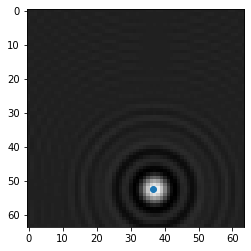

In [7]:
# Retrieve particle position

def get_position_of_particle(image):
    return image.get_property("position")

position_of_particle = get_position_of_particle(output_image)

plt.imshow(np.squeeze(output_image), cmap='gray')
plt.scatter(position_of_particle[1], position_of_particle[0])
plt.show()

## 6. Define the neural network model

We will use a predefined neural network model obtained by calling the function `convolutional` (see also [models_example](../examples/models_example.ipynb)). This model is a convolutional neural network with a dense top. It receives as input an image of shape `(64, 64, 1)` and outputs two scalar values corresponing to the x and y position of the particle.

The model can be customized using the following arguments

* `input_shape`: Size of the images to be analyzed.

* `conv_layers_dimensions`: Number of convolutions in each convolutional layer.
    
* `dense_layers_dimensions`: Number of units in each dense layer.
        
* `number_of_outputs`: Number of units in the output layer.

* `output_activation`: The activation function applied to the output layer.

* `loss`: The loss function of the network.

* `optimizer`: The the optimizer used for training.

* `metrics`: Additional metrics to evaulate during training.

In [8]:
model = dt.models.convolutional(
    input_shape=(64, 64, 1), 
    number_of_outputs=2
)

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 16)        160       
_________________________________________________________________
activation (Activation)      (None, 64, 64, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)       

## 7. Define image generator

Generators are objects that feed models with images and their corresponging labels during training. They are as instances of the class `ContinuousGenerator` (see also [generators_example](../examples/generators_example.ipynb)). This method takes the following inputs:
* `feature`: A feature (see also [features_example](../examples/features_example.ipynb) that resolves images used to train a model (here, `imaged_particle_with_random_position`)
* `label_function`: A function that takes an image as input and returns the label for that image (here, `get_position_of_particle`)
* `batch_size`: The number of images per batch
* `min_data_size` The number of images to create starting training
* `max_data_size` The maximum images to hold in memory at one point in time.

In [9]:
# Function that retireves the position of a particle 
# and divides it by 64 to get values between 0 and 1
def get_scaled_position_of_particle(image):
    return image.get_property("position") / IMAGE_SIZE

generator = dt.generators.ContinuousGenerator(
    imaged_particle_with_random_position, 
    get_scaled_position_of_particle, 
    batch_size=4,
    min_data_size=1024,
    max_data_size=2048
)

## 8. Train the model

The model is trained by calling the method `.fit()` with the generator we defined in the previous step. Be patient, this might take some time (several minutes).

If you are training on a CPU, consider reducing the number of epochs to around 100. The gain after that is marginal.

In [10]:
with generator:
    model.fit(
        generator,
        epochs=400
    )

Generating 1041 / 1024 samples before starting training
Epoch 1/400
260/260 [==============================] - 1s 4ms/step - loss: 0.0783
Epoch 2/400
260/260 [==============================] - 1s 4ms/step - loss: 0.0260
Epoch 3/400
260/260 [==============================] - 1s 4ms/step - loss: 0.0207
Epoch 4/400
260/260 [==============================] - 1s 4ms/step - loss: 0.0207
Epoch 5/400
260/260 [==============================] - 1s 4ms/step - loss: 0.0167
Epoch 6/400
260/260 [==============================] - 1s 4ms/step - loss: 0.0157
Epoch 7/400
260/260 [==============================] - 1s 4ms/step - loss: 0.0123
Epoch 8/400
260/260 [==============================] - 1s 4ms/step - loss: 0.0139
Epoch 9/400
260/260 [==============================] - 1s 4ms/step - loss: 0.0142
Epoch 10/400
260/260 [==============================] - 1s 4ms/step - loss: 0.0118
Epoch 11/400
260/260 [==============================] - 1s 4ms/step - loss: 0.0121
Epoch 12/400
260/260 [==================

260/260 [==============================] - 1s 4ms/step - loss: 0.0054
Epoch 100/400
260/260 [==============================] - 1s 4ms/step - loss: 0.0049
Epoch 101/400
260/260 [==============================] - 1s 4ms/step - loss: 0.0055
Epoch 102/400
260/260 [==============================] - 1s 5ms/step - loss: 0.0060
Epoch 103/400
260/260 [==============================] - 1s 4ms/step - loss: 0.0050
Epoch 104/400
260/260 [==============================] - 1s 4ms/step - loss: 0.0056
Epoch 105/400
260/260 [==============================] - 1s 4ms/step - loss: 0.0050
Epoch 106/400
260/260 [==============================] - 1s 4ms/step - loss: 0.0053
Epoch 107/400
260/260 [==============================] - 1s 4ms/step - loss: 0.0051
Epoch 108/400
260/260 [==============================] - 1s 4ms/step - loss: 0.0059
Epoch 109/400
260/260 [==============================] - 1s 5ms/step - loss: 0.0057
Epoch 110/400
260/260 [==============================] - 1s 5ms/step - loss: 0.0053
Epoch 

260/260 [==============================] - 1s 4ms/step - loss: 0.0034
Epoch 294/400
260/260 [==============================] - 1s 4ms/step - loss: 0.0035
Epoch 295/400
260/260 [==============================] - 1s 4ms/step - loss: 0.0036
Epoch 296/400
260/260 [==============================] - 1s 4ms/step - loss: 0.0033
Epoch 297/400
260/260 [==============================] - 1s 4ms/step - loss: 0.0037
Epoch 298/400
260/260 [==============================] - 1s 4ms/step - loss: 0.0040
Epoch 299/400
260/260 [==============================] - 1s 4ms/step - loss: 0.0039
Epoch 300/400
260/260 [==============================] - 1s 4ms/step - loss: 0.0037
Epoch 301/400
260/260 [==============================] - 1s 4ms/step - loss: 0.0035
Epoch 302/400
260/260 [==============================] - 1s 4ms/step - loss: 0.0035
Epoch 303/400
260/260 [==============================] - 1s 4ms/step - loss: 0.0033
Epoch 304/400
260/260 [==============================] - 1s 4ms/step - loss: 0.0035
Epoch 

## 9. Visualize the model performance

We can now use the trained model to measure the particle position in images previously unseen by the model.

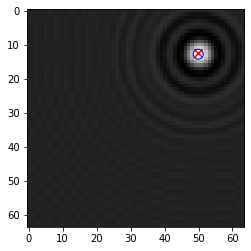

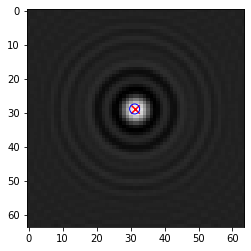

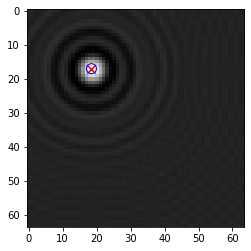

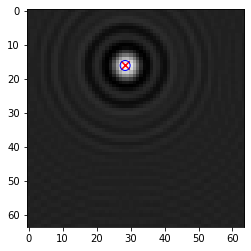

In [12]:
# generator[0] extracts one batch of images from the generator
images, real_positions = generator[0]

measured_positions = model.predict(images)

for i in range(images.shape[0]):
    
    image = np.squeeze(images[i])
    
    measured_position_x = measured_positions[i, 1] * IMAGE_SIZE
    measured_position_y = measured_positions[i, 0] * IMAGE_SIZE

    real_position_x = real_positions[i, 1] * IMAGE_SIZE
    real_position_y = real_positions[i, 0] * IMAGE_SIZE

    plt.imshow(image, cmap='gray')
    plt.scatter(real_position_x, real_position_y, s=70, c='r', marker='x')
    plt.scatter(measured_position_x, measured_position_y, s=100, marker='o', facecolor='none', edgecolors='b')
    plt.show()